### Import libraries

In [3]:
#!pip install twython

In [4]:
#!pip install vaderSentiment

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

In [7]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### Load Data

In [8]:
df = pd.read_csv('sentimentdataset.csv')

In [9]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [13]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,Unnamed: 0.1,int64,0,0.000000
1,Unnamed: 0,int64,0,0.000000
2,Text,object,0,0.000000
3,Sentiment,object,0,0.000000
4,Timestamp,object,0,0.000000
5,User,object,0,0.000000
6,Platform,object,0,0.000000
7,Hashtags,object,0,0.000000
8,Retweets,float64,0,0.000000
9,Likes,float64,0,0.000000


In [15]:
df.duplicated().sum()

0

In [16]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [18]:
for column in df.columns:
    num_distinc_values = len(df[column].unique())
    print(f"{column}: {num_distinc_values} distinct values")

Unnamed: 0.1: 732 distinct values
Unnamed: 0: 732 distinct values
Text: 707 distinct values
Sentiment: 279 distinct values
Timestamp: 683 distinct values
User: 685 distinct values
Platform: 4 distinct values
Hashtags: 697 distinct values
Retweets: 26 distinct values
Likes: 38 distinct values
Country: 115 distinct values
Year: 14 distinct values
Month: 12 distinct values
Day: 31 distinct values
Hour: 22 distinct values


### Feature Enginering

In [19]:
# Drop Columns
df = df.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags', 'Day', 'Hour', 'Sentiment'])

In [20]:
df['Platform'].value_counts()

Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64

In [21]:
df['Platform'] = df['Platform'].str.strip()

In [22]:
df.Platform.value_counts()

Platform
Instagram    258
Twitter      243
Facebook     231
Name: count, dtype: int64

In [23]:
df['Country'].value_counts()

Country
USA               59
USA               55
UK                49
Canada            44
Australia         41
                  ..
Netherlands        1
USA                1
Germany            1
France             1
USA                1
Name: count, Length: 115, dtype: int64

In [24]:
df.Country = df.Country.str.strip()

In [25]:
df.Country.value_counts()

Country
USA               188
UK                143
Canada            135
Australia          75
India              70
Brazil             17
France             16
Japan              15
Germany            14
Italy              11
Spain               6
South Africa        6
Greece              5
Netherlands         4
Switzerland         3
Portugal            2
Austria             2
Belgium             2
Denmark             2
Czech Republic      2
Sweden              2
Colombia            1
Scotland            1
Kenya               1
Jamaica             1
Ireland             1
China               1
Norway              1
Cambodia            1
Maldives            1
Peru                1
Jordan              1
Thailand            1
Name: count, dtype: int64

In [36]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day_of_Week'] = df['Timestamp'].dt.day_name()

In [28]:
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'Juny',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df.Month = df.Month.map(month_mapping)
df.Month = df.Month.astype('object')

#### Text

In [29]:
df.Text

0       Enjoying a beautiful day at the park!        ...
1       Traffic was terrible this morning.           ...
2       Just finished an amazing workout! 💪          ...
3       Excited about the upcoming weekend getaway!  ...
4       Trying out a new recipe for dinner tonight.  ...
                             ...                        
727    Collaborating on a science project that receiv...
728    Attending a surprise birthday party organized ...
729    Successfully fundraising for a school charity ...
730    Participating in a multicultural festival, cel...
731    Organizing a virtual talent show during challe...
Name: Text, Length: 732, dtype: object

In [31]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
    
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

df['Clean_Text'] = df['Text'].apply(clean)

#### Unique Columns

In [37]:
specified_columns = ['Platform','Country', 'Year','Month','Day_of_Week']

for col in specified_columns:
    total_unique_values = df[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = df[col].value_counts()

    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.LIGHTBLACK_EX, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n')

Total unique values for Platform: 3
Instagram: 258
Twitter: 243
Facebook: 231


Total unique values for Country: 33
USA: 188
UK: 143
Canada: 135
Australia: 75
India: 70
Brazil: 17
France: 16
Japan: 15
Germany: 14
Italy: 11
Spain: 6
South Africa: 6
Greece: 5
Netherlands: 4
Switzerland: 3
Portugal: 2
Austria: 2
Belgium: 2
Denmark: 2
Czech Republic: 2
Sweden: 2
Colombia: 1
Scotland: 1
Kenya: 1
Jamaica: 1
Ireland: 1
China: 1
Norway: 1
Cambodia: 1
Maldives: 1
Peru: 1
Jordan: 1
Thailand: 1


Total unique values for Year: 14
2023: 289
2019: 73
2020: 69
2021: 63
2022: 63
2018: 56
2017: 43
2016: 38
2015: 19
2011: 4
2012: 4
2013: 4
2014: 4
2010: 3


Total unique values for Month: 12
February: 85
January: 82
August: 78
September: 77
Juny: 71
July: 62
April: 51
November: 49
October: 48
May: 46
March: 44
December: 39


Total unique values for Day_of_Week: 7
Sunday: 119
Saturday: 115
Tuesday: 110
Friday: 108
Monday: 97
Thursday: 95
Wednesday: 88




### EDA

In [38]:
df1 = df.copy()

In [39]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

                     Clean_Text  Vader_Score Sentiment
0         enjoy beauti day park       0.4939  positive
1          traffic terribl morn       0.0000   neutral
2           finish amaz workout       0.0000   neutral
3   excit upcom weekend getaway       0.0000   neutral
4  tri new recip dinner tonight       0.0000   neutral


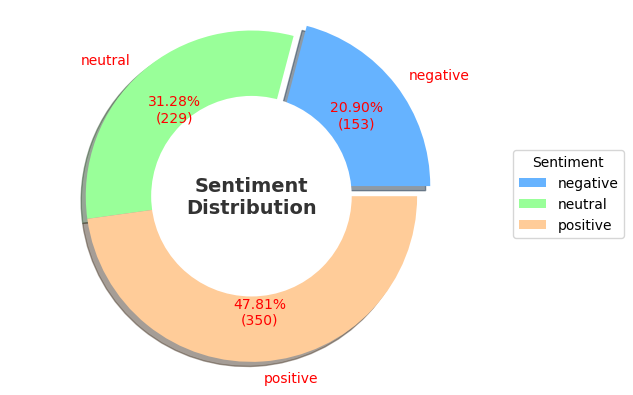

In [44]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.1, 0, 0)  

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color = 'white', fc = 'white', linewidth = 1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha = 'center', va = 'center', fontsize = 14, fontweight = 'bold', color = '#333333')

ax.legend(sentiment_counts.index, title = 'Sentiment', loc = 'center left', bbox_to_anchor = (1, 0, 0.5, 1))

ax.axis('equal')
plt.show()

#### Year

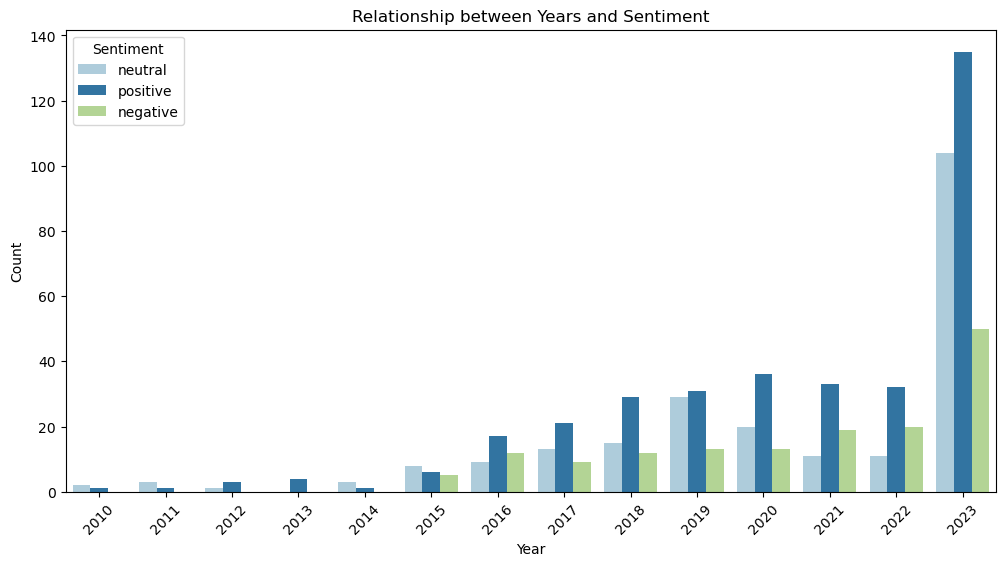

In [45]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'Year', hue = 'Sentiment', data = df1, palette = 'Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

#### Month

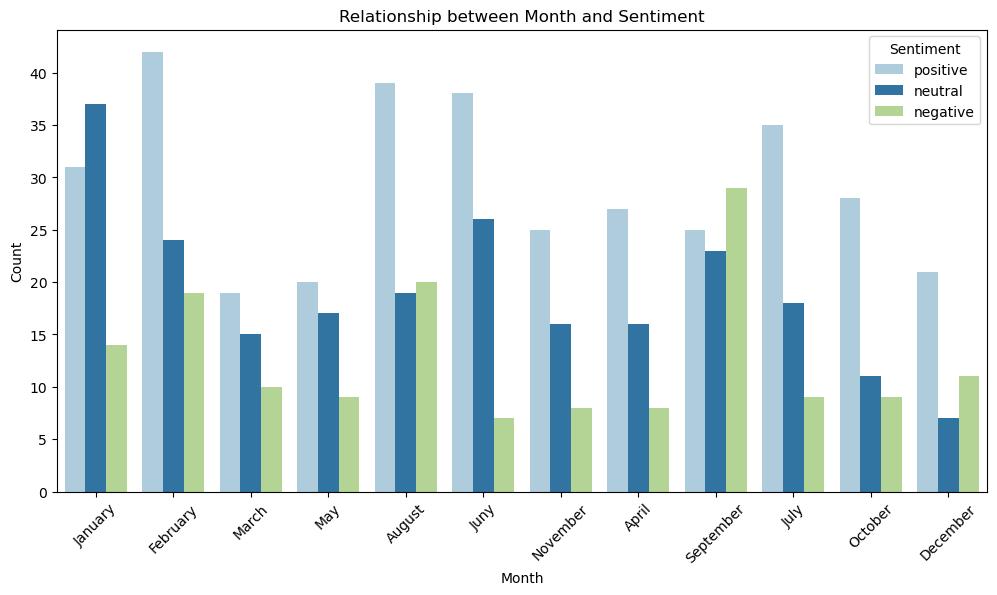

In [47]:
plt.figure(figsize= (12, 6))
sns.countplot(x = 'Month', hue = 'Sentiment', data = df1, palette = 'Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

#### Day of Week

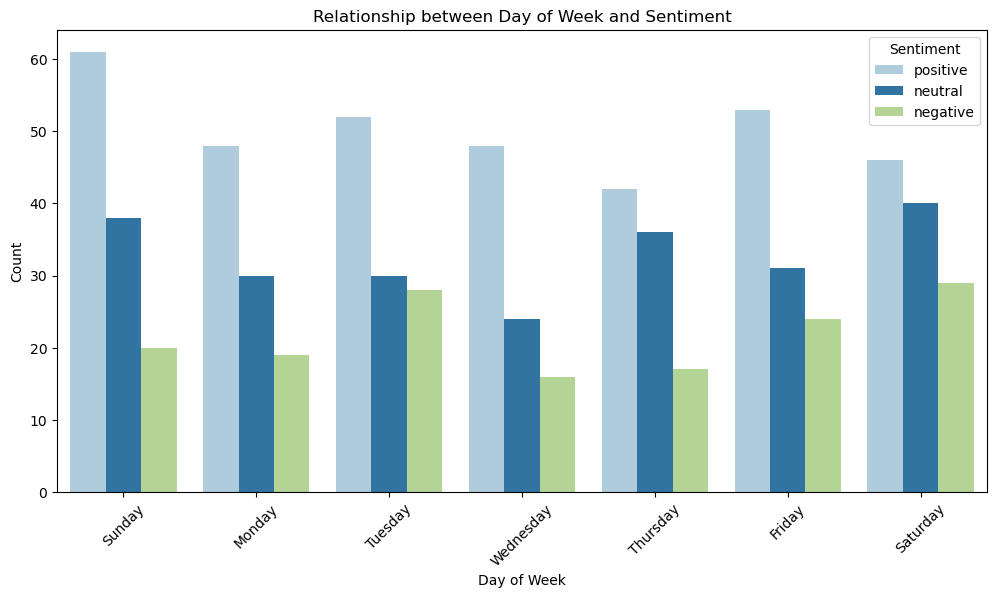

In [50]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'Day_of_Week', hue = 'Sentiment', data = df1, palette = 'Paired')
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

#### Platform

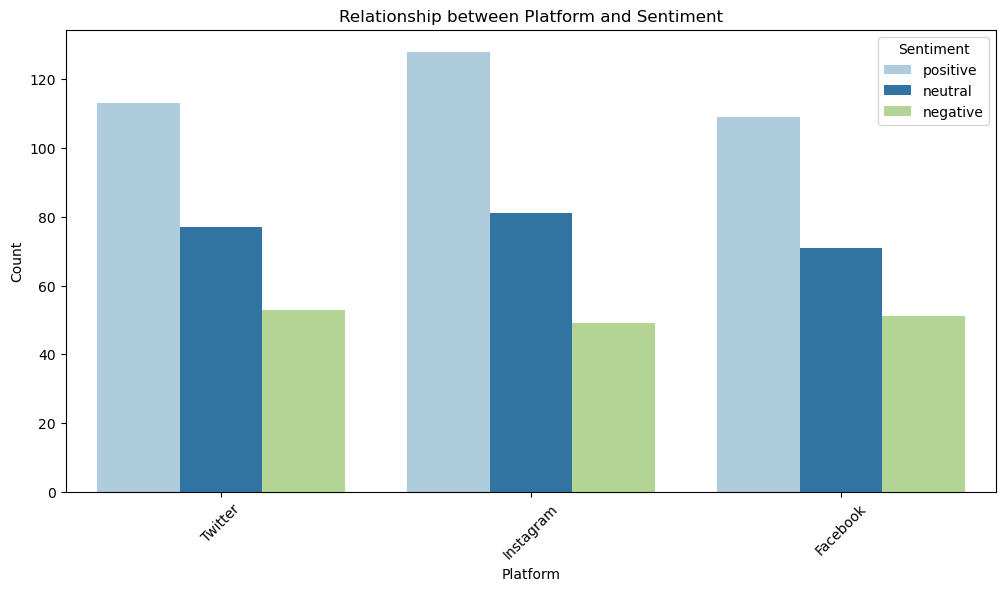

In [51]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'Platform', hue = 'Sentiment', data = df1, palette = 'Paired')
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

#### Country

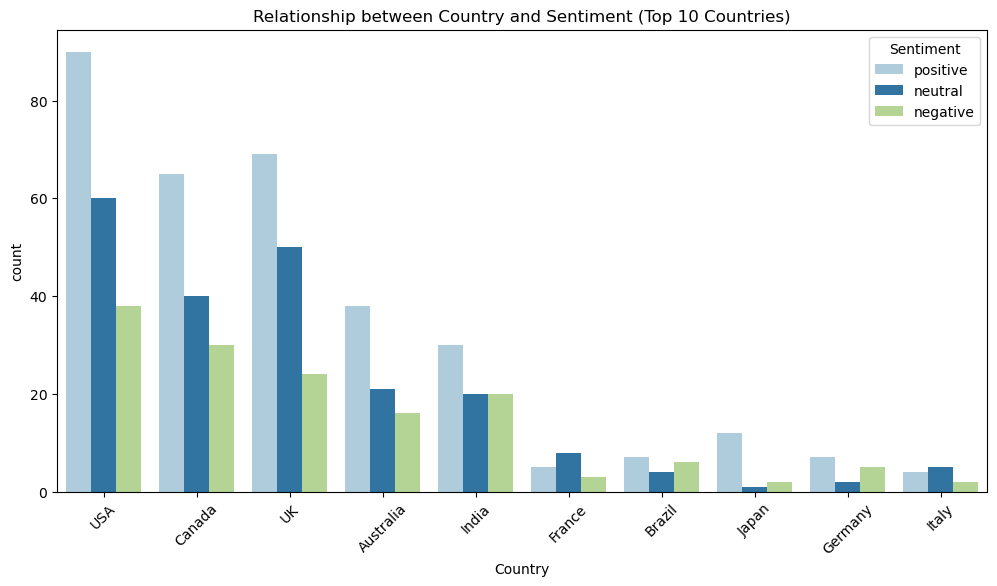

In [56]:
plt.figure(figsize = (12, 6))

top_10_countries = df1['Country'].value_counts().head(10).index
df_top_10_countries = df1[df1['Country'].isin(top_10_countries)]

sns.countplot(x = 'Country', hue = 'Sentiment', data = df_top_10_countries, palette = 'Paired')
plt.title('Relationship between Country and Sentiment (Top 10 Countries)')
plt.xlabel('Country')
plt.xticks(rotation = 45)
plt.show()